In [1]:
#packages
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygam
import sklearn
import lightgbm as lgb
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings('ignore') 
import random
np.random.seed(42)
random.seed(42)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LassoCV

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV, RepeatedKFold, KFold , cross_val_predict
from patsy import dmatrix, build_design_matrices
from optuna.samplers import TPESampler
from sklearn.tree import DecisionTreeRegressor
from pygam import LinearGAM, s, l
from sklearn.ensemble import RandomForestRegressor, StackingRegressor


print(f'Package versions: \n')
print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'pygam {pygam.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'optuna {optuna.__version__}')



Package versions: 

numpy 1.26.4
scipy 1.13.1
pandas 2.2.2
seaborn 0.13.2
pygam 0.9.1
scikit-learn 1.6.1
optuna 4.3.0


In [2]:
df_olist_customers_dataset = pd.read_csv('olist_customers_dataset.csv')
df_olist_geolocation_dataset = pd.read_csv('olist_geolocation_dataset.csv')
df_olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv')
df_olist_order_payments_dataset = pd.read_csv('olist_order_payments_dataset.csv')
df_olist_order_reviews_dataset = pd.read_csv('olist_order_reviews_dataset.csv')
df_olist_orders_dataset = pd.read_csv('olist_orders_dataset.csv')
df_olist_products_dataset = pd.read_csv('olist_products_dataset.csv')
df_olist_sellers_dataset = pd.read_csv('olist_sellers_dataset.csv')
df_product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.rename(columns={'review_id': 'customer_id'})

df_temp = pd.merge(df_olist_order_items_dataset, df_olist_order_payments_dataset, on='order_id')
df_order_based = pd.merge(df_temp, df_olist_orders_dataset, on='order_id')

df_order_medium = pd.merge(df_order_based, df_olist_products_dataset, on='product_id')
df_order_final = pd.merge(df_order_medium, df_olist_sellers_dataset, on='seller_id')
df_customer = pd.merge(df_olist_customers_dataset, df_olist_orders_dataset, on='customer_id')
df_merged = pd.merge(df_order_final, df_customer, on='order_id')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   order_id                         117601 non-null  object 
 1   order_item_id                    117601 non-null  int64  
 2   product_id                       117601 non-null  object 
 3   seller_id                        117601 non-null  object 
 4   shipping_limit_date              117601 non-null  object 
 5   price                            117601 non-null  float64
 6   freight_value                    117601 non-null  float64
 7   payment_sequential               117601 non-null  int64  
 8   payment_type                     117601 non-null  object 
 9   payment_installments             117601 non-null  int64  
 10  payment_value                    117601 non-null  float64
 11  customer_id_x                    117601 non-null  object 
 12  or

In [3]:
df = df_merged

df['order_purchase_timestamp_y'] = pd.to_datetime(df['order_purchase_timestamp_y'])

clv_df = df.groupby('customer_unique_id').agg(
    total_payment=('payment_value', 'sum'),
    order_count=('order_id', 'nunique'),
    first_purchase=('order_purchase_timestamp_y', 'min'),
    last_purchase=('order_purchase_timestamp_y', 'max')
).reset_index()


clv_df['first_purchase'] = pd.to_datetime(clv_df['first_purchase'])
clv_df['last_purchase'] = pd.to_datetime(clv_df['last_purchase'])
clv_df['AOV'] = clv_df['total_payment'] / clv_df['order_count']
clv_df['lifespan_months'] = (clv_df['last_purchase'] - clv_df['first_purchase']) / pd.Timedelta(days=30)
clv_df['lifespan_days'] = (clv_df['last_purchase'] - clv_df['first_purchase']).dt.days

In [4]:
print(clv_df['lifespan_months'].describe())
print(clv_df['lifespan_days'].describe())

count    95419.000000
mean         0.089451
std          0.842135
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.102806
Name: lifespan_months, dtype: float64
count    95419.000000
mean         2.672308
std         25.211811
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        633.000000
Name: lifespan_days, dtype: float64


In [5]:
df[['customer_unique_id', 'order_id', 'order_purchase_timestamp_y']].drop_duplicates().groupby('customer_unique_id').size().value_counts()

1     92506
2      2673
3       192
4        29
5         9
6         5
7         3
9         1
16        1
Name: count, dtype: int64

In [6]:
clv_df['CLV'] = clv_df['AOV'] * clv_df['order_count']
df = df.merge(clv_df[['customer_unique_id', 'CLV']], on='customer_unique_id', how='left')
print(df[['customer_unique_id', 'CLV']].head())

                 customer_unique_id     CLV
0  871766c5855e863f6eccc05f988b23cb   72.19
1  eb28e67c4c0b83846050ddfb8a35d051  284.56
2  3818d81c6709e39d06b2738a8d3a2474  216.87
3  af861d436cfc08b2c2ddefd0ba074622   25.78
4  64b576fb70d441e8f1b2d7d446e483c5  218.04


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   order_id                         117601 non-null  object        
 1   order_item_id                    117601 non-null  int64         
 2   product_id                       117601 non-null  object        
 3   seller_id                        117601 non-null  object        
 4   shipping_limit_date              117601 non-null  object        
 5   price                            117601 non-null  float64       
 6   freight_value                    117601 non-null  float64       
 7   payment_sequential               117601 non-null  int64         
 8   payment_type                     117601 non-null  object        
 9   payment_installments             117601 non-null  int64         
 10  payment_value                    117601 non-

In [8]:
print(df.columns.tolist())

['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'customer_id_x', 'order_status_x', 'order_purchase_timestamp_x', 'order_approved_at_x', 'order_delivered_carrier_date_x', 'order_delivered_customer_date_x', 'order_estimated_delivery_date_x', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id_y', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_status_y', 'order_purchase_timestamp_y', 'order_approved_at_y', 'order_delivered_carrier_date_y', 'order_delivered_customer_date_y', 'order_estimated_delivery_date_y', 'CLV']


In [9]:
cols_to_drop = ['customer_id_x','order_status_x', 'order_purchase_timestamp_x',
                'order_approved_at_x', 'order_delivered_carrier_date_x', 'order_delivered_customer_date_x', 
                'order_estimated_delivery_date_x', 'product_name_lenght', 'product_description_lenght',
                'product_photos_qty','customer_id_y']
df.drop(columns=cols_to_drop, inplace=True)

In [10]:
missing_info = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)
missing_df = pd.DataFrame({'Missing Values': missing_info, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

print("Columns with missing values:")
display(missing_df)

Columns with missing values:


,Missing Values,Percent
order_delivered_customer_date_y,2567,2.182805
product_category_name,1698,1.443865
order_delivered_carrier_date_y,1245,1.058664
product_weight_g,20,0.017007
product_length_cm,20,0.017007
product_height_cm,20,0.017007
product_width_cm,20,0.017007
order_approved_at_y,15,0.012755


In [11]:
df.dropna(inplace=True)
print(df.isnull().sum())

order_id                           0
order_item_id                      0
product_id                         0
seller_id                          0
shipping_limit_date                0
price                              0
freight_value                      0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
product_category_name              0
product_weight_g                   0
product_length_cm                  0
product_height_cm                  0
product_width_cm                   0
seller_zip_code_prefix             0
seller_city                        0
seller_state                       0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_status_y                     0
order_purchase_timestamp_y         0
order_approved_at_y                0
order_delivered_carrier_date_y     0
o

In [12]:
df['order_delivered_customer_date_y'] = pd.to_datetime(df['order_delivered_customer_date_y'], errors='coerce')
df['order_estimated_delivery_date_y'] = pd.to_datetime(df['order_estimated_delivery_date_y'], errors='coerce')

df['delivery_delay'] = (
    df['order_estimated_delivery_date_y'].dt.date - 
    df['order_delivered_customer_date_y'].dt.date
).apply(lambda x: x.days)


df['delivery_delay'].value_counts().sort_index()

delivery_delay
-188    1
-181    1
-175    1
-167    1
-166    1
       ..
 109    1
 124    2
 135    1
 140    1
 147    2
Name: count, Length: 196, dtype: int64

In [13]:
df['product_volume_cm3'] = (
    df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
)

print(df[['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_volume_cm3']].head())

   product_length_cm  product_height_cm  product_width_cm  product_volume_cm3
0               28.0                9.0              14.0              3528.0
1               50.0               30.0              40.0             60000.0
2               33.0               13.0              33.0             14157.0
3               16.0               10.0              15.0              2400.0
4               35.0               40.0              30.0             42000.0


In [14]:
categorical_cols = [
    'payment_type', 'product_category_name', 'seller_city', 'seller_state',
    'customer_city', 'customer_state'
]

numeric_categorical = [
    'payment_sequential', 'payment_installments',
    'seller_zip_code_prefix', 'customer_zip_code_prefix'
]

numeric_continuous = [
    'price', 'freight_value', 'payment_value', 'delivery_delay',
    'product_weight_g', 'product_volume_cm3'
]

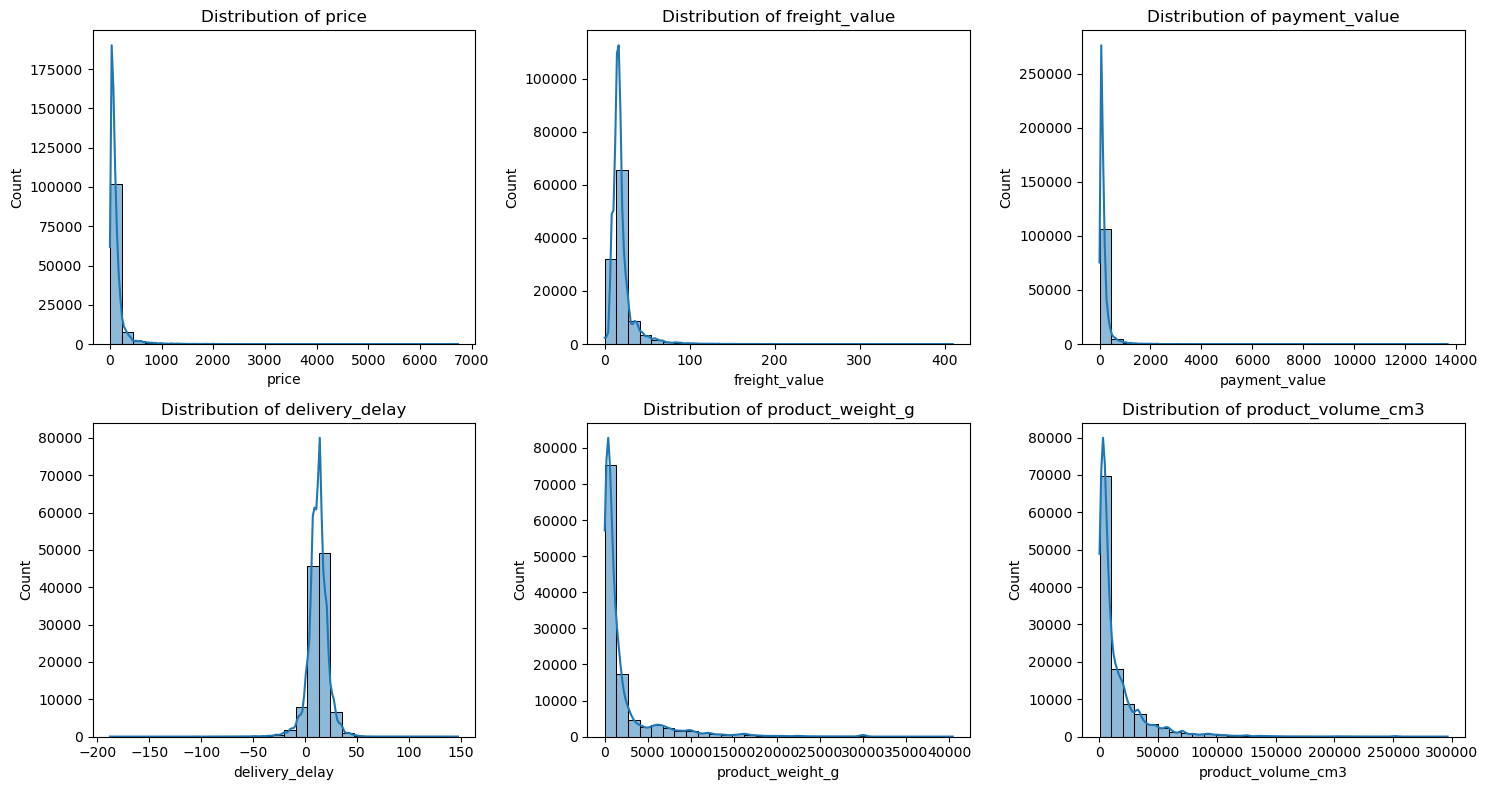

In [15]:
continuous_explore = [
    'price', 'freight_value', 'payment_value', 'delivery_delay',
    'product_weight_g', 'product_volume_cm3'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()  
for i, feature in enumerate(continuous_explore):
    sns.histplot(df[feature].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

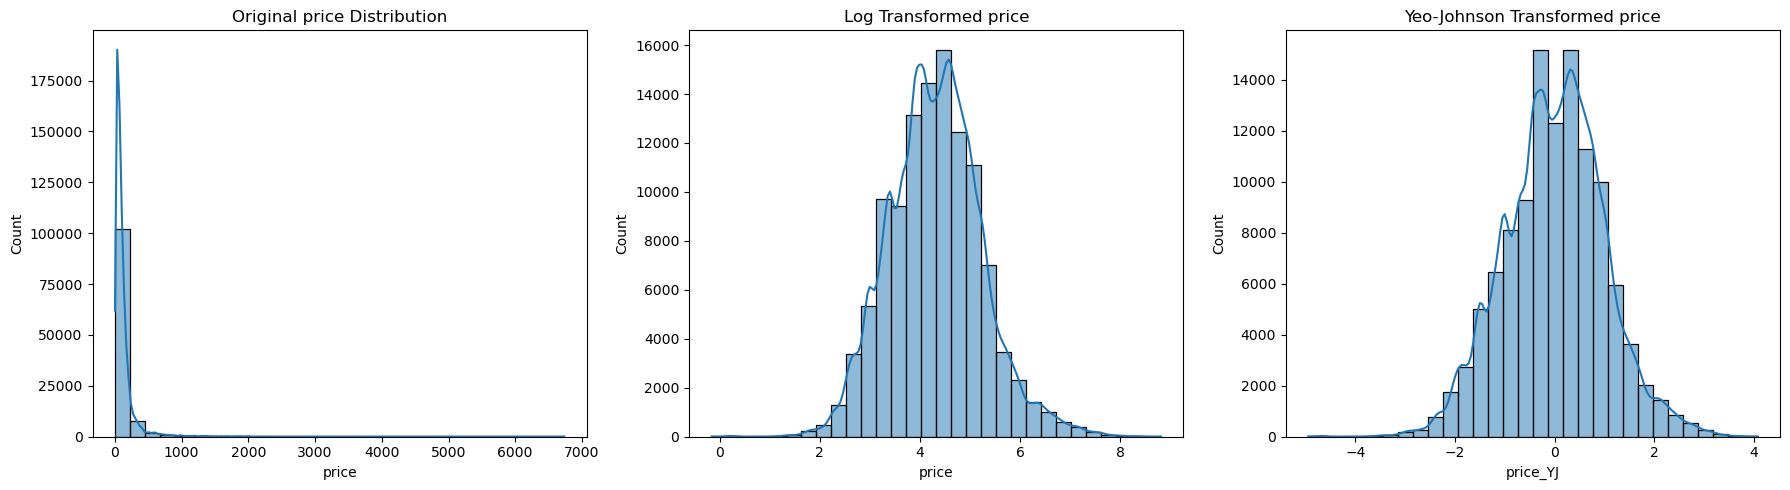

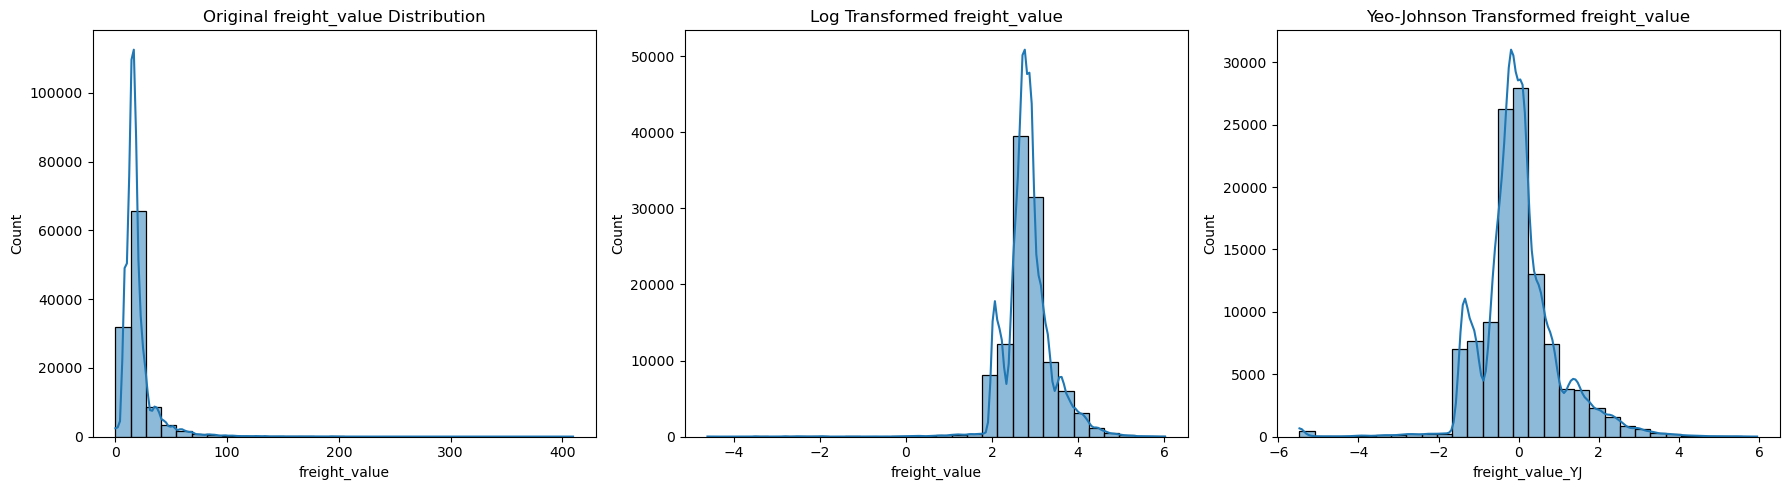

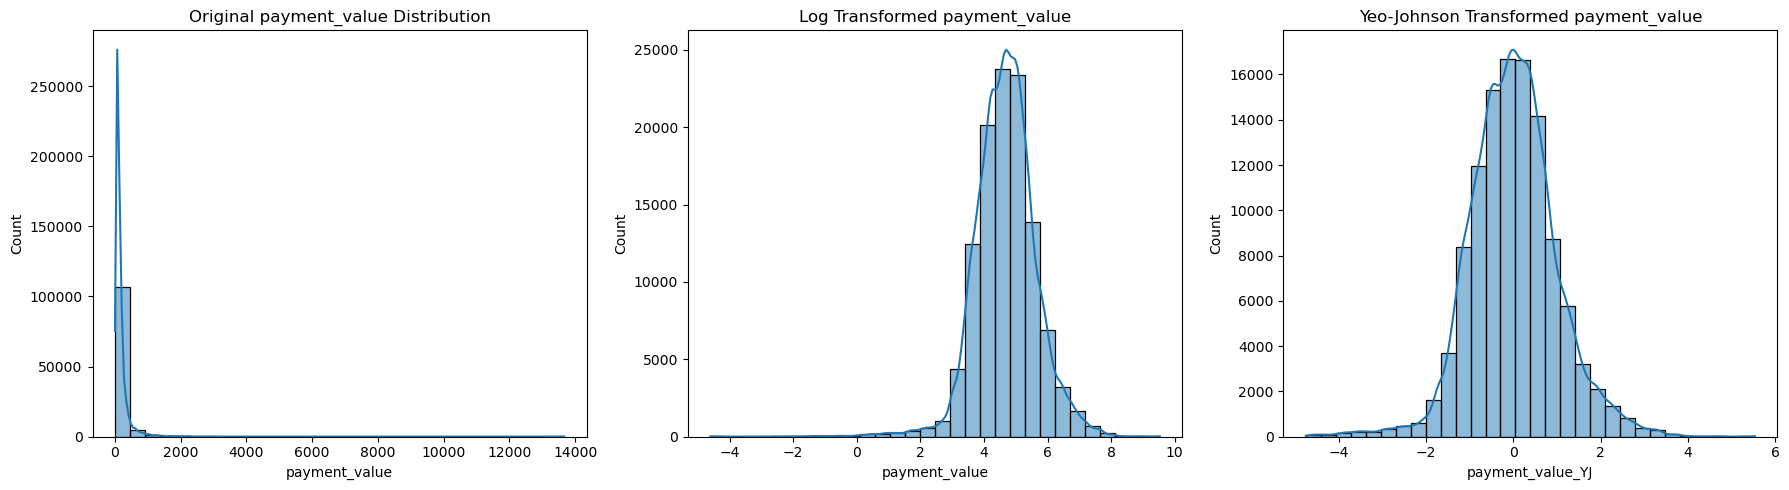

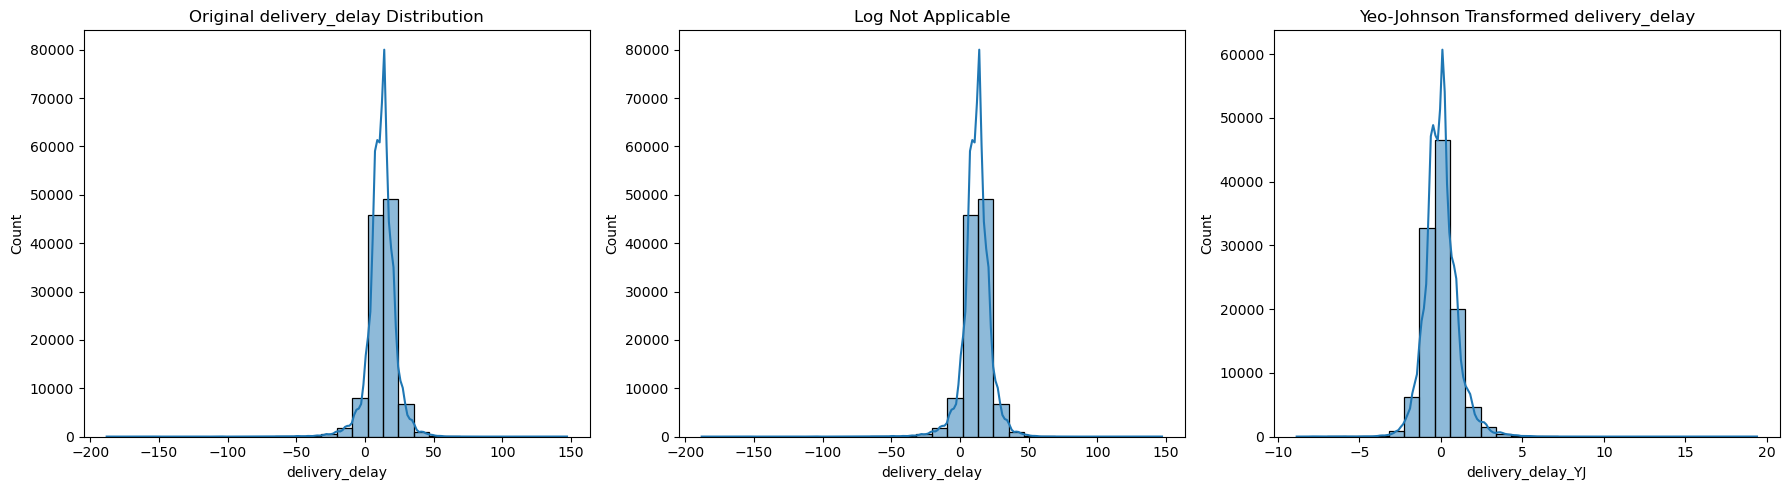

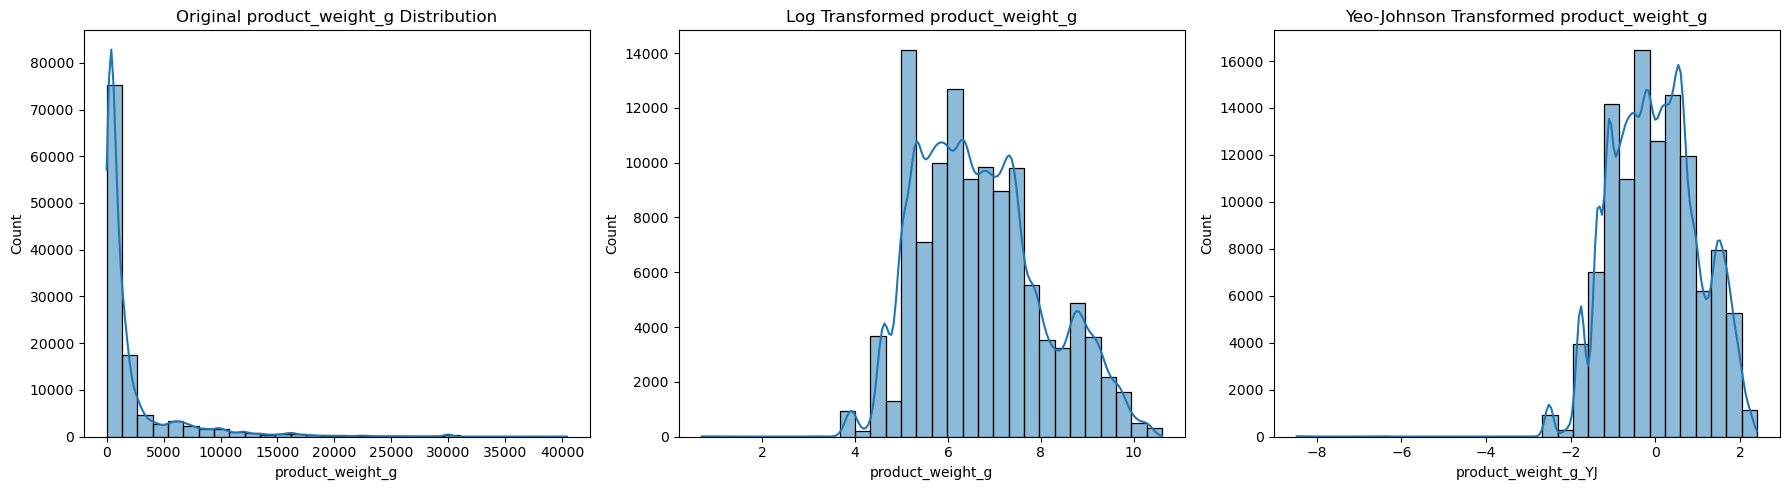

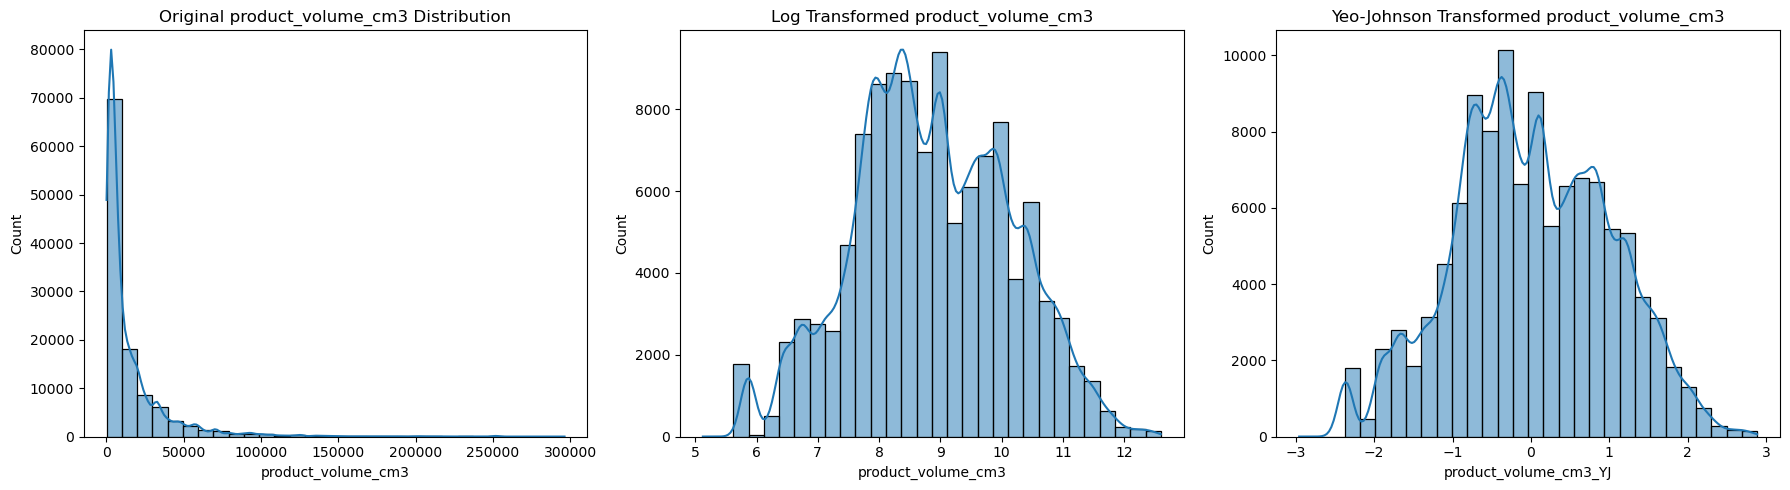

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
yj = PowerTransformer(method='yeo-johnson')
df['price_YJ'] = yj.fit_transform(df[['price']])
df['freight_value_YJ'] = yj.fit_transform(df[['freight_value']])
df['payment_value_YJ'] = yj.fit_transform(df[['payment_value']])
df['delivery_delay_YJ'] = yj.fit_transform(df[['delivery_delay']])
df['product_weight_g_YJ'] = yj.fit_transform(df[['product_weight_g']])
df['product_volume_cm3_YJ'] = yj.fit_transform(df[['product_volume_cm3']])

sns.histplot(df['price'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Original price Distribution')
sns.histplot(np.log(df['price']), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Transformed price')
sns.histplot(df['price_YJ'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Yeo-Johnson Transformed price')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['freight_value'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Original freight_value Distribution')
sns.histplot(np.log(df['freight_value'][df['freight_value'] > 0]), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Transformed freight_value')
sns.histplot(df['freight_value_YJ'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Yeo-Johnson Transformed freight_value')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['payment_value'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Original payment_value Distribution')
sns.histplot(np.log(df['payment_value'][df['payment_value'] > 0]), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Transformed payment_value')
sns.histplot(df['payment_value_YJ'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Yeo-Johnson Transformed payment_value')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['delivery_delay'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Original delivery_delay Distribution')
sns.histplot(df['delivery_delay'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Not Applicable')
sns.histplot(df['delivery_delay_YJ'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Yeo-Johnson Transformed delivery_delay')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['product_weight_g'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Original product_weight_g Distribution')
sns.histplot(np.log(df['product_weight_g'][df['product_weight_g'] > 0]), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Transformed product_weight_g')
sns.histplot(df['product_weight_g_YJ'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Yeo-Johnson Transformed product_weight_g')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['product_volume_cm3'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Original product_volume_cm3 Distribution')
sns.histplot(np.log(df['product_volume_cm3'][df['product_volume_cm3'] > 0]), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Transformed product_volume_cm3')
sns.histplot(df['product_volume_cm3_YJ'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Yeo-Johnson Transformed product_volume_cm3')
plt.tight_layout()
plt.show()


In [17]:
yj_cols = [
    'price_YJ', 'freight_value_YJ', 'payment_value_YJ',
    'delivery_delay_YJ', 'product_weight_g_YJ', 'product_volume_cm3_YJ'
]

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[yj_cols]),
    columns=[f'{col}_scaled' for col in yj_cols],
    index=df.index
)
df = pd.concat([df, df_scaled], axis=1)

In [18]:
all_cat_vars = categorical_cols + numeric_categorical

# 统计每个变量的唯一值数量
cardinality_info = pd.DataFrame({
    'Variable': all_cat_vars,
    'Cardinality': [df[col].nunique() for col in all_cat_vars]
})

# 按基数从高到低排序
cardinality_info = cardinality_info.sort_values(by='Cardinality', ascending=False).reset_index(drop=True)

# 展示结果
display(cardinality_info)

,Variable,Cardinality
0,customer_zip_code_prefix,14844
1,customer_city,4073
2,seller_zip_code_prefix,2136
3,seller_city,588
4,product_category_name,73
5,customer_state,27
6,payment_sequential,26
7,payment_installments,24
8,seller_state,22
9,payment_type,4


In [19]:
low_cardinality_vars = [
    'payment_type',  'seller_state',
    'customer_state', 'order_status_y', 'payment_sequential'
]
df[low_cardinality_vars] = df[low_cardinality_vars].astype(str)
df_ohe = pd.get_dummies(df[low_cardinality_vars], drop_first=False)
df = pd.concat([df, df_ohe], axis=1)
df.drop(columns=low_cardinality_vars, inplace=True)


target = 'CLV'
high_cardinality_vars = [
    'seller_city', 'customer_city', 'product_category_name',
    'seller_zip_code_prefix', 'customer_zip_code_prefix'
]
for col in high_cardinality_vars:
    mean_map = df.groupby(col)[target].mean()
    df[f'{col}_TE'] = df[col].map(mean_map)

df.drop(columns=high_cardinality_vars, inplace=True)

In [20]:
scaled_cols = [f'{col}_scaled' for col in yj_cols]
ohe_cols = [col for col in df.columns if any(var + '_' in col for var in low_cardinality_vars)]
te_cols = [f'{col}_TE' for col in high_cardinality_vars]
final_feature_cols = scaled_cols + ohe_cols + te_cols
X = df[final_feature_cols]
y = df['CLV']


print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")



Feature matrix shape: (113390, 92)
Target vector shape: (113390,)


In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_valid.shape}")
print(f"Test size: {X_test.shape}")

Train size: (68034, 92)
Validation size: (22678, 92)
Test size: (22678, 92)


# Round 1: Preliminary Comparison (8 Models) 
In the first round, we compared 8 different models (Linear Regression, KNN, Decision Tree, Random Forest, Linear Spline, Cubic Spline, Natural Cubic Spline, GAM) to evaluate their basic performance.
The objective was:
- To use a unified dataset
- To assess the RMSE, R², and MAE metrics
- To select the top 6 models with the best performance to advance to the next round 
Each model is trained based on the same feature engineering results.

In [22]:
results_R1 = [] 

### Linear Regression （baseline model)

In [23]:

# a basic pipeline with just linear regression
lr_pipeline = Pipeline([
    ('lr', LinearRegression())
])

# training model
lr_pipeline.fit(X_train, y_train)

#predict on validation set
lr_pred = lr_pipeline.predict(X_valid)

# evaluate predictors
lr_rmse = np.sqrt(mean_squared_error(y_valid, lr_pred))
lr_r2 = r2_score(y_valid, lr_pred)
lr_mae = mean_absolute_error(y_valid, lr_pred)

# print result
print(f"\n Linear Regression Performance:")
print(f" RMSE: {lr_rmse:.2f}")
print(f" R²: {lr_r2:.4f}")
print(f" MAE: {lr_mae:.2f}")

# save into results_R1 list
results_R1.append({
    "Model": "Linear Regression",
    "RMSE": lr_rmse,
    "R2": lr_r2,
    "MAE": lr_mae
})


 Linear Regression Performance:
 RMSE: 1008.91
 R²: 0.5025
 MAE: 302.21


### KNN

In [24]:
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# set up a pipeline
knn_pipeline = Pipeline([
    ('knn', KNeighborsRegressor())  
])

# define the hyperparameters we want to test
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']    # try equally-weighted and distance-weighted neighbors
}

# use grid search to test each combination and find the best one
knn = GridSearchCV(knn_pipeline, param_grid, cv=rkf, scoring='neg_mean_squared_error', verbose=1)
knn.fit(X_train, y_train)


# print the best combo
print(f'\ nBest hyperparameters: {knn.best_params_}')
knn = knn.best_estimator_

# predict and evaluate
knn_pred = knn.predict(X_valid)
knn_rmse = np.sqrt(mean_squared_error(y_valid, knn_pred))
knn_r2 = r2_score(y_valid, knn_pred)
knn_mae = mean_absolute_error(y_valid, knn_pred)

# print results
print(f"\n KNN Performance:")
print(f" RMSE: {knn_rmse:.2f}")
print(f" R²: {knn_r2:.4f}")
print(f" MAE: {knn_mae:.2f}")

# save into results_R1 list
results_R1.append({
    "Model": "KNN",
    "RMSE": knn_rmse,
    "R2": knn_r2,
    "MAE": knn_mae
})


Fitting 10 folds for each of 8 candidates, totalling 80 fits
\ nBest hyperparameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}

 KNN Performance:
 RMSE: 349.60
 R²: 0.9403
 MAE: 130.46


### Linear Spline Regression

In [25]:
# use optuna to test different combinations of smoothing parameters (lambda)
def gam_objective(trial):
    n_features = X_train.shape[1]
    
    lambdas = [trial.suggest_float(f'lambda_{i}', 1e-4, 1e4, log=True) for i in range(n_features)]

    terms = s(0)
    for i in range(1, n_features):
        terms += s(i)
        
    # fit the model using current lambda settings
    model = LinearGAM(terms, lam=lambdas)
    model.fit(X_train, y_train)

    # return GCV （Generalized Cross Validation） score：
    return model.statistics_['GCV']

# set up Optuna with a TPE sampler
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# find best lambdas
study.optimize(gam_objective, n_trials=30, timeout=60)

# 
best_lambdas = list(study.best_params.values())

# build the model with best lambdas
terms = s(0)
for i in range(1, X_train.shape[1]):
    terms += s(i)

optimized_gam = LinearGAM(terms, lam=best_lambdas)
optimized_gam.fit(X_train, y_train)

# predict
lspline_pred = optimized_gam.predict(X_valid)

# evaluate
lspline_rmse = np.sqrt(mean_squared_error(y_valid, lspline_pred))
lspline_r2 = r2_score(y_valid, lspline_pred)
lspline_mae = mean_absolute_error(y_valid, lspline_pred)

# print results
print(f"\n Linear Spline Regression Performance:")
print(f" RMSE: {lspline_rmse:.2f}")
print(f" R²: {lspline_r2:.4f}")
print(f" MAE: {lspline_mae:.2f}")

# save into results_R1 list
results_R1.append({
    "Model": "Linear Spline",
    "RMSE": lspline_rmse,
    "R2": lspline_r2,
    "MAE": lspline_mae
})


 Linear Spline Regression Performance:
 RMSE: 679.73
 R²: 0.7742
 MAE: 161.20


### Natural Cubic Spline 

In [26]:
# hold the spline-transformed training and validation features
spline_features_train = []
spline_features_valid = []

# go through each feature column and apply natural cubic spline transformation
for col in X_train.columns:
    if X_train[col].nunique() <= 1:

        # if the column doesn't have variation, skip it
        print(f"Skipping column '{col}' due to low variability.")
        continue
    try:

        # use cubic regression spline ('cr') with 4 degrees of freedom, and remove intercept
        formula = f"cr(x, df=4) - 1"

        # convert training and val into numpy arrays
        x_train_col = X_train[col].astype(float).to_numpy()
        x_valid_col = X_valid[col].astype(float).to_numpy()

        # generate spline basis for training data by patsy's dmatrix
        X_spline = dmatrix(formula, {"x": x_train_col}, return_type='dataframe')
        spline_features_train.append(X_spline)

        # use the same spline design to transform the validation set
        X_spline_val = build_design_matrices([X_spline.design_info], {"x": x_valid_col})[0]
        X_spline_val_df = pd.DataFrame(X_spline_val, columns=X_spline.design_info.column_names)
        spline_features_valid.append(X_spline_val_df)

    except Exception as e:
        print(f"Skipping column '{col}' due to error: {e}")

# combine all spline-transformed features into final matrices
X_train_spline = pd.concat(spline_features_train, axis=1)
X_valid_spline = pd.concat(spline_features_valid, axis=1)

# train a linear regression 
model_spline = LinearRegression()
model_spline.fit(X_train_spline, y_train)

# predict
nspline_pred = model_spline.predict(X_valid_spline)

#evaluate
nspline_rmse = np.sqrt(mean_squared_error(y_valid, nspline_pred))
nspline_r2 = r2_score(y_valid, nspline_pred)
nspline_mae = mean_absolute_error(y_valid, nspline_pred)

# print results
print(f"\n Natural Cubic Spline Regression Performance:")
print(f" RMSE: {nspline_rmse:.2f}")
print(f" R²: {nspline_r2:.4f}")
print(f" MAE: {nspline_mae:.2f}")

# save into results_R1 list
results_R1.append({
    "Model": "Natural Spline",
    "RMSE": nspline_rmse,
    "R2": nspline_r2,
    "MAE": nspline_mae
})

Skipping column 'payment_sequential_22' due to low variability.
Skipping column 'payment_sequential_23' due to low variability.
Skipping column 'payment_sequential_26' due to low variability.

 Natural Cubic Spline Regression Performance:
 RMSE: 813.98
 R²: 0.6762
 MAE: 214.61


### LightGBM

In [27]:
# prepare LightGBM training data
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

# try different parameter settings
def objective(trial):
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'feature_pre_filter': False,
        'verbose': -1
    }

# use cross-validation to evaluate parameters

    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=5000,
        nfold=5,
        stratified=False,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

# return the lowest validation loss
    best_score = min(cv_results['valid l2-mean'])
    trial.set_user_attr('num_trees', len(cv_results['valid l2-mean']))

    return best_score

# let optuna try parameter combinations
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=30, timeout=60)  # 先设置这个吧,稍微快点，后面改？

best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01
})

# train the final model with the best params found
best_num_boost_round = study.best_trial.user_attrs['num_trees']

final_lgbm = lgb.train(best_params, train_data, num_boost_round=best_num_boost_round)

lgb_pred = final_lgbm.predict(X_valid)

lgb_rmse = np.sqrt(mean_squared_error(y_valid, lgb_pred))
lgb_r2 = r2_score(y_valid, lgb_pred)
lgb_mae = mean_absolute_error(y_valid, lgb_pred)

# print outputs
print(f"\n LightGBM Performance:")
print(f" RMSE: {lgb_rmse:.4f}")
print(f" R²: {lgb_r2:.4f}")
print(f" MAE: {lgb_mae:.4f}")

# save into results_R1 list
results_R1.append({
    "Model": "LightGBM",
    "RMSE": lgb_rmse,
    "R2": lgb_r2,
    "MAE": lgb_mae
})

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid's l2: 54306.5 + 41785.9

 LightGBM Performance:
 RMSE: 221.5743
 R²: 0.9760
 MAE: 45.0383


### Decision Tree Regressor

In [28]:
# test different levels of tree pruning
alphas = np.linspace(0, 0.02, 21)  
model = DecisionTreeRegressor(min_samples_leaf=5)  
search_space = {'ccp_alpha': alphas}

# use GridSearch to search for the best pruning level
dt_search = GridSearchCV(model, search_space, cv=5, scoring='neg_mean_squared_error')
dt_search.fit(X_train, y_train)
dt = dt_search.best_estimator_

print('Best parameters found by grid search:', dt_search.best_params_, '\n')

# predict on validation set
dt_pred = dt.predict(X_valid)

# evaluate
dt_rmse = np.sqrt(mean_squared_error(y_valid, dt_pred))
dt_r2 = r2_score(y_valid, dt_pred)
dt_mae = mean_absolute_error(y_valid, dt_pred)

# print results
print(f"\n Decision Tree Regressor Performance:")
print(f" RMSE: {dt_rmse:.2f}")
print(f" R²: {dt_r2:.4f}")
print(f" MAE: {dt_mae:.2f}")

# save into results_R1 list
results_R1.append({
    "Model": "Decision Tree",
    "RMSE": dt_rmse,
    "R2": dt_r2,
    "MAE": dt_mae
})

Best parameters found by grid search: {'ccp_alpha': 0.02} 


 Decision Tree Regressor Performance:
 RMSE: 397.50
 R²: 0.9228
 MAE: 58.70


### Random Forest Regressor

In [29]:
def objective(trial):
    # ask Optuna to suggest key hyperparameters
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])

    model = RandomForestRegressor(
        n_estimators=100,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        random_state=1,
        n_jobs=-1
    )

    # evaluate using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = (-scores.mean())**0.5
    return rmse

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# use Optuna to find best random forest settings
study.optimize(objective, n_trials=50, timeout=60)  #改？

# print best parameters found
best_params = study.best_params
print("Best parameters found:", best_params)

# use best model found
rf_model = RandomForestRegressor( n_estimators=1000,**best_params, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_valid)

# evaluate
rf_rmse = np.sqrt(mean_squared_error(y_valid, rf_pred))
rf_r2 = r2_score(y_valid, rf_pred)
rf_mae = mean_absolute_error(y_valid, rf_pred)

# print results
print(f"\n Random Forest Regressor Performance:")
print(f" RMSE: {rf_rmse:.2f}")
print(f" R²: {rf_r2:.4f}")
print(f" MAE: {rf_mae:.2f}")

# save into results_R1 list
results_R1.append({
    "Model": "Random Forest",
    "RMSE": rf_rmse,
    "R2": rf_r2,
    "MAE": rf_mae
})

Best parameters found: {'min_samples_leaf': 3, 'max_features': 80}

 Random Forest Regressor Performance:
 RMSE: 189.41
 R²: 0.9825
 MAE: 46.17


### GAM - Generalised Additive Model

In [30]:
# define the optuna function
def gam_objective(trial):
    # optimize the first 5 lambdas
    lam_list = [trial.suggest_float(f"lambda_{i}", 0.001, 100.0, log=True) for i in range(5)]
    
    # other parameters are set at 1.0 
    total_terms = X_train.shape[1]  
    lam_list += [1.0] * (total_terms - 5)

    # build gam model
    model = LinearGAM(lam=lam_list)

    # fit and return GCV
    model.fit(X_train, y_train)
    return model.statistics_['GCV']
    
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(gam_objective, n_trials=20, timeout=60)  # 改？？

best_lambdas = list(study.best_params.values()) + [1.0] * (X_train.shape[1] - 5)

# use the best lambda to fit the final GAM
best_gam = LinearGAM(lam=best_lambdas)
best_gam.fit(X_train, y_train)


y_pred_val = best_gam.predict(X_valid)

# predict
gam_pred = optimized_gam.predict(X_valid)

#evaluate
gam_rmse = np.sqrt(mean_squared_error(y_valid, gam_pred))
gam_r2 = r2_score(y_valid, gam_pred)
gam_mae = mean_absolute_error(y_valid, gam_pred)

# print the results
print(f"\n Generalized Additive Model (GAM) Performance:")
print(f" RMSE: {gam_rmse:.2f}")
print(f" R²: {gam_r2:.4f}")
print(f" MAE: {gam_mae:.2f}")

# save into results_R1 list
results_R1.append({
    "Model": "GAM",
    "RMSE": gam_rmse,
    "R2": gam_r2,
    "MAE": gam_mae
})


 Generalized Additive Model (GAM) Performance:
 RMSE: 679.73
 R²: 0.7742
 MAE: 161.20


### Round 1 results

Top 6 Models by RMSE:


,Model,RMSE,R2,MAE
1,Random Forest,189.407933,0.982465,46.171467
2,LightGBM,221.574316,0.976004,45.038286
3,KNN,349.595867,0.940264,130.457406
4,Decision Tree,397.502558,0.922771,58.700301
5,Linear Spline,679.727395,0.774175,161.203608
6,GAM,679.727395,0.774175,161.203608


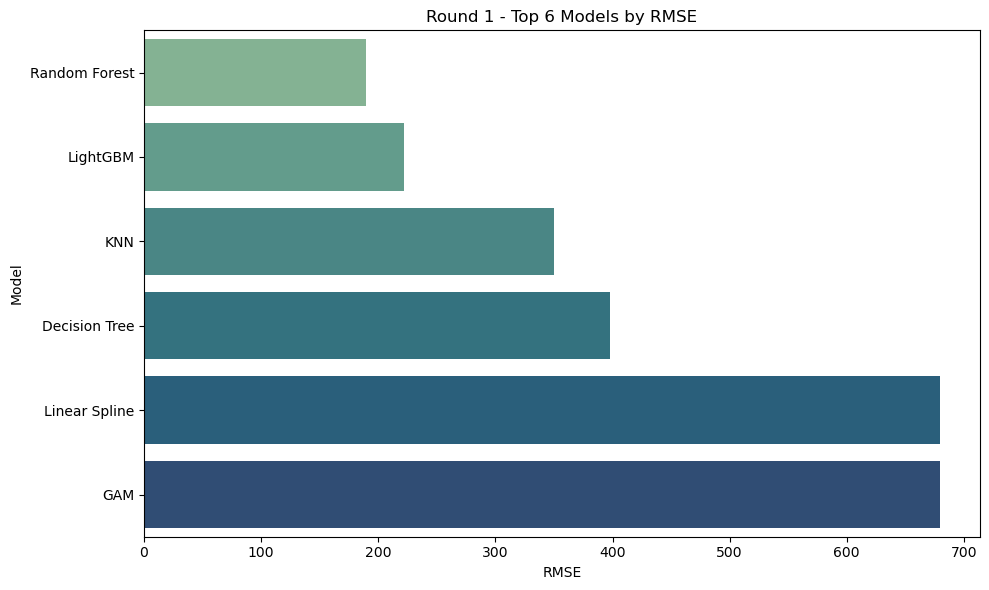

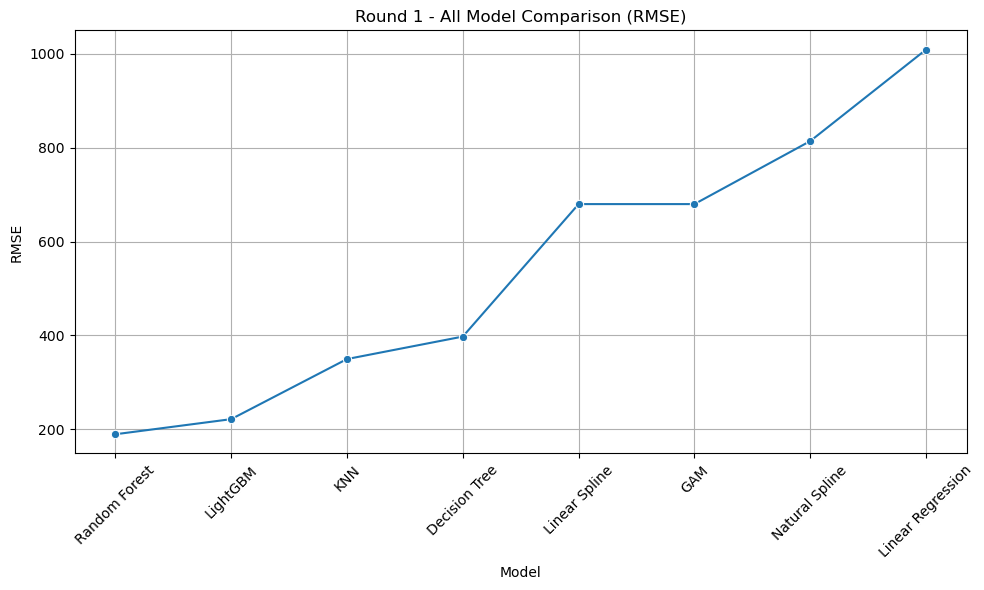

In [31]:
results_R1_df = pd.DataFrame(results_R1)

# Top 6
top6 = results_R1_df.sort_values("RMSE").head(6).reset_index(drop=True)
top6.index = top6.index + 1 

print("Top 6 Models by RMSE:")
display(top6)

#visualization_1
plt.figure(figsize=(10, 6))
sns.barplot(data=top6, x="RMSE", y="Model", palette="crest")
plt.title("Round 1 - Top 6 Models by RMSE")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

#visualization_2
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_R1_df.sort_values("RMSE"), x="Model", y="RMSE", marker="o")
plt.title("Round 1 - All Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Round 2: Further Evaluation of the First 6 Models (Data Ratio 0.5/0.5) 
In this round, we conducted a more detailed evaluation on the 6 models that performed the best in Round 1.
- Utilized a larger training set (Train/Val = 0.5/0.5)
- Excluded the models with significant fluctuations
- Re-screened the top 4 models based on RMSE to proceed to the final refinement stage

In [32]:
# round 2: divide the original training data into two parts, making it a training and validation set (50/50)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.5, random_state=42)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_valid.shape}")

# create an empty list
results_R2 = []

Train size: (45356, 92)
Validation size: (45356, 92)


### KNN_Round 2

In [33]:
# create repeated K-fold cross-validation: 5-fold repeated 2 times
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# set up a pipeline
knn_pipeline = Pipeline([
    ('knn', KNeighborsRegressor())  
])

# define the hyperparameters we want to test
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

# use grid search to test each combination and find the best one
knn = GridSearchCV(knn_pipeline, param_grid, cv=rkf, scoring='neg_mean_squared_error', verbose=1)
knn.fit(X_train, y_train)

# print the best combo
print(f'\nBest hyperparameters: {knn.best_params_}')
knn = knn.best_estimator_

# predict and evaluate
knn_pred = knn.predict(X_valid)
knn_rmse = np.sqrt(mean_squared_error(y_valid, knn_pred))
knn_r2 = r2_score(y_valid, knn_pred)
knn_mae = mean_absolute_error(y_valid, knn_pred)

# print results
print(f"\n KNN Performance:")
print(f" RMSE: {knn_rmse:.2f}")
print(f" R²: {knn_r2:.4f}")
print(f" MAE: {knn_mae:.2f}")

# save into results_R2 list
results_R2.append({
    "Model": "KNN",
    "RMSE": knn_rmse,
    "R2": knn_r2,
    "MAE": knn_mae
})

Fitting 10 folds for each of 8 candidates, totalling 80 fits

Best hyperparameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}

 KNN Performance:
 RMSE: 406.67
 R²: 0.9304
 MAE: 149.82


### Linear Spline Regression_Round 2

In [34]:
# use optuna to test different combinations of smoothing parameters (lambda)
def gam_objective(trial):
    n_features = X_train.shape[1]
    
    lambdas = [trial.suggest_float(f'lambda_{i}', 1e-4, 1e4, log=True) for i in range(n_features)]

    terms = s(0)
    for i in range(1, n_features):
        terms += s(i)

    # fit the model using current lambda settings
    model = LinearGAM(terms, lam=lambdas)
    model.fit(X_train, y_train)

    # return GCV （Generalized Cross Validation） score：
    return model.statistics_['GCV']

# set up optuna with a TPE sampler
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# find best lambdas
study.optimize(gam_objective, n_trials=30, timeout=60)

best_lambdas = list(study.best_params.values())

# build the model with best lambdas
terms = s(0)
for i in range(1, X_train.shape[1]):
    terms += s(i)

optimized_gam = LinearGAM(terms, lam=best_lambdas)
optimized_gam.fit(X_train, y_train)

# predict
lspline_pred = optimized_gam.predict(X_valid)

# evaluate
lspline_rmse = np.sqrt(mean_squared_error(y_valid, lspline_pred))
lspline_r2 = r2_score(y_valid, lspline_pred)
lspline_mae = mean_absolute_error(y_valid, lspline_pred)

# print results
print(f"\n Linear Spline Regression Performance:")
print(f" RMSE: {lspline_rmse:.2f}")
print(f" R²: {lspline_r2:.4f}")
print(f" MAE: {lspline_mae:.2f}")


# save into results list
results_R2.append({
    "Model": "Linear Spline",
    "RMSE": lspline_rmse,
    "R2": lspline_r2,
    "MAE": lspline_mae
})


 Linear Spline Regression Performance:
 RMSE: 731.74
 R²: 0.7746
 MAE: 162.90


### Natural Cubic Spline_Round 2

In [35]:
# hold the spline-transformed training and validation features
spline_features_train = []
spline_features_valid = []

# go through each feature column and apply natural cubic spline transformation
for col in X_train.columns:
    if X_train[col].nunique() <= 1:

         # if the column doesn't have variation, skip it
        print(f"Skipping column '{col}' due to low variability.")
        continue
    try:
        
        # use cubic regression spline ('cr') with 4 degrees of freedom, and remove intercept
        formula = f"cr(x, df=4) - 1"

        # convert training and val into numpy arrays
        x_train_col = X_train[col].astype(float).to_numpy()
        x_valid_col = X_valid[col].astype(float).to_numpy()

        # generate spline basis for training data by patsy's dmatrix
        X_spline = dmatrix(formula, {"x": x_train_col}, return_type='dataframe')
        spline_features_train.append(X_spline)

        # use the same spline design to transform the validation set
        X_spline_val = build_design_matrices([X_spline.design_info], {"x": x_valid_col})[0]
        X_spline_val_df = pd.DataFrame(X_spline_val, columns=X_spline.design_info.column_names)
        spline_features_valid.append(X_spline_val_df)

    except Exception as e:
        print(f"Skipping column '{col}' due to error: {e}")

# combine all spline-transformed features into final matrices
X_train_spline = pd.concat(spline_features_train, axis=1)
X_valid_spline = pd.concat(spline_features_valid, axis=1)

# train a linear regression 
model_spline = LinearRegression()
model_spline.fit(X_train_spline, y_train)

# predict
nspline_pred = model_spline.predict(X_valid_spline)

#evaluate
nspline_rmse = np.sqrt(mean_squared_error(y_valid, nspline_pred))
nspline_r2 = r2_score(y_valid, nspline_pred)
nspline_mae = mean_absolute_error(y_valid, nspline_pred)

# print results
print(f"\n Natural Cubic Spline Regression Performance:")
print(f" RMSE: {nspline_rmse:.2f}")
print(f" R²: {nspline_r2:.4f}")
print(f" MAE: {nspline_mae:.2f}")

# save into results_R2 list
results_R2.append({
    "Model": "Natural Spline",
    "RMSE": nspline_rmse,
    "R2": nspline_r2,
    "MAE": nspline_mae
})

Skipping column 'payment_sequential_22' due to low variability.
Skipping column 'payment_sequential_23' due to low variability.
Skipping column 'payment_sequential_26' due to low variability.

 Natural Cubic Spline Regression Performance:
 RMSE: 825.93
 R²: 0.7128
 MAE: 214.72


### Decision Tree Regressor_Round 2

In [36]:
# test different levels of tree pruning
alphas = np.linspace(0, 0.02, 21)  
model = DecisionTreeRegressor(min_samples_leaf=5)  
search_space = {'ccp_alpha': alphas}

# using the  GridSearch to search for the best pruning level
dt_search = GridSearchCV(model, search_space, cv=5, scoring='neg_mean_squared_error')
dt_search.fit(X_train, y_train)
dt = dt_search.best_estimator_

print('Best parameters found by grid search:', dt_search.best_params_, '\n')

# predict on validation set
dt_pred = dt.predict(X_valid)

# evaluate
dt_rmse = np.sqrt(mean_squared_error(y_valid, dt_pred))
dt_r2 = r2_score(y_valid, dt_pred)
dt_mae = mean_absolute_error(y_valid, dt_pred)

# print results
print(f"\n Decision Tree Regressor Performance:")
print(f" RMSE: {dt_rmse:.2f}")
print(f" R²: {dt_r2:.4f}")
print(f" MAE: {dt_mae:.2f}")

# save into results_R2 list
results_R2.append({
    "Model": "Decision Tree",
    "RMSE": dt_rmse,
    "R2": dt_r2,
    "MAE": dt_mae
})

Best parameters found by grid search: {'ccp_alpha': 0.012} 


 Decision Tree Regressor Performance:
 RMSE: 736.61
 R²: 0.7716
 MAE: 77.29


### Random Forest Regressor_Round 2

In [37]:
def objective(trial):
     # ask optuna to suggest key hyperparameters
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])

    model = RandomForestRegressor(
        n_estimators=100,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        random_state=1,
        n_jobs=-1
    )

    # evaluate using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = (-scores.mean())**0.5
    return rmse

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# use Optuna to find best random forest settings
study.optimize(objective, n_trials=50, timeout=60)

# print best parameters found
best_params = study.best_params
print("Best parameters found:", best_params)

# use best model found
rf_model = RandomForestRegressor(
    n_estimators=1000,
    **best_params,
    random_state=1,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# predict
rf_pred = rf_model.predict(X_valid)

# evaluate
rf_rmse = np.sqrt(mean_squared_error(y_valid, rf_pred))
rf_r2 = r2_score(y_valid, rf_pred)
rf_mae = mean_absolute_error(y_valid, rf_pred)

# print results
print(f"\n Random Forest Regressor Performance:")
print(f" RMSE: {rf_rmse:.2f}")
print(f" R²: {rf_r2:.4f}")
print(f" MAE: {rf_mae:.2f}")

# save into results_R2 list
results_R2.append({
    "Model": "Random Forest",
    "RMSE": rf_rmse,
    "R2": rf_r2,
    "MAE": rf_mae
})

Best parameters found: {'min_samples_leaf': 2, 'max_features': 90}

 Random Forest Regressor Performance:
 RMSE: 415.88
 R²: 0.9272
 MAE: 56.29


### GAM - Generalised Additive Model_Round 2

In [38]:
# define the objective function ->
def gam_objective(trial):
    n_features = X_train.shape[1]

    # suggest values for only the first two lambda parameters
    lam0 = trial.suggest_float("lambda_0", 1e-4, 1e4, log=True)
    lam1 = trial.suggest_float("lambda_1", 1e-4, 1e4, log=True)
    lambdas = [lam0, lam1] + [1.0] * (n_features - 2)  # 

    # Define terms：spline + linear
    terms = s(0) + s(1)
    for i in range(2, n_features):
        terms += l(i)

    model = LinearGAM(terms, lam=lambdas)
    model.fit(X_train, y_train)

    return model.statistics_['GCV']

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(gam_objective, n_trials=30, timeout=60)  #改？

# recreate terms
terms = s(0) + s(1)
for i in range(2, X_train.shape[1]):
    terms += l(i)

# 
best_lambdas = list(study.best_params.values()) + [1.0] * (X_train.shape[1] - 2)

# fit the model
optimized_gam = LinearGAM(terms, lam=best_lambdas)
optimized_gam.fit(X_train, y_train)

#
gam_pred = optimized_gam.predict(X_valid)
gam_rmse = np.sqrt(mean_squared_error(y_valid, gam_pred))
gam_r2 = r2_score(y_valid, gam_pred)
gam_mae = mean_absolute_error(y_valid, gam_pred)

print(f"\n Generalized Additive Model (GAM) Performance:")
print(f" RMSE: {gam_rmse:.2f}")
print(f" R²: {gam_r2:.4f}")
print(f" MAE: {gam_mae:.2f}")

results_R2.append({
    "Model": "GAM",
    "RMSE": gam_rmse,
    "R2": gam_r2,
    "MAE": gam_mae
})


 Generalized Additive Model (GAM) Performance:
 RMSE: 995.36
 R²: 0.5829
 MAE: 294.64


### Round 2 results

Top 4 Models by RMSE:


,Model,RMSE,R2,MAE
1,KNN,406.670360,0.930381,149.822332
2,Random Forest,415.876947,0.927193,56.294404
3,Linear Spline,731.736004,0.774600,162.902054
4,Decision Tree,736.607278,0.771589,77.285683


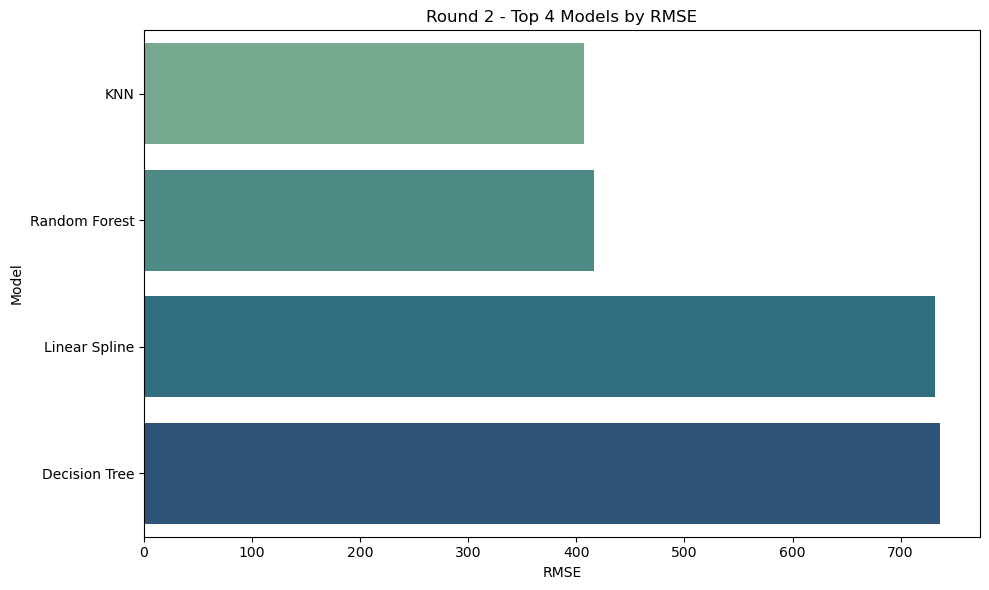

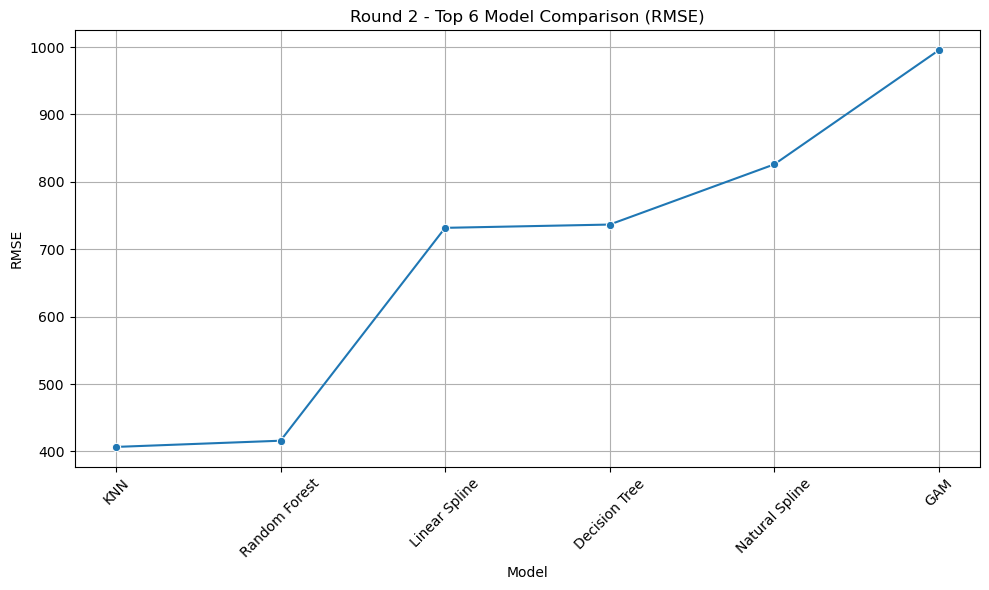

In [39]:
results_R2_df = pd.DataFrame(results_R2)

# Top 4 models
top4 = results_R2_df.sort_values("RMSE").head(4).reset_index(drop=True)
top4.index = top4.index + 1 
print("Top 4 Models by RMSE:")
display(top4)

# visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=top4, x="RMSE", y="Model", palette="crest")
plt.title("Round 2 - Top 4 Models by RMSE")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_R2_df.sort_values("RMSE"), x="Model", y="RMSE", marker="o")
plt.title("Round 2 - Top 6 Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Round 3: KFold Cross-Validation Evaluation (Top 4 Models) 
To enhance the stability of the generalization ability assessment, we conducted 5-fold cross-validation on the Top 4 models.
- Each model was trained and predicted multiple times under different data splits.
- The average RMSE / R² / MAE was evaluated.
- The Best Single Model with the most stable performance was ultimately selected.

In [40]:
top4_model_names = ['Random Forest', 'KNN', 'Linear Spline', 'Decision Tree']

In [41]:
# build spline-transformed features
def build_spline_features(X_train, X_valid, df=4):
    from patsy import dmatrix
    spline_train, spline_valid = [], []

    for col in X_train.columns:
        x_train_col = X_train[col].astype(float).to_numpy()
        x_valid_col = X_valid[col].astype(float).to_numpy()

        # skip constant columns (spline basis not meaningful)
        if np.min(x_train_col) == np.max(x_train_col):
            continue

        try:
            formula = f"cr(x, df={df}) - 1"
            X_spline = dmatrix(formula, {"x": x_train_col}, return_type='dataframe')
            X_spline_val = dmatrix(formula, {"x": x_valid_col}, return_type='dataframe')

            spline_train.append(X_spline)
            spline_valid.append(X_spline_val)
        except:
            continue  # if spline transformation fails  -> skip

    return pd.concat(spline_train, axis=1), pd.concat(spline_valid, axis=1)

In [42]:
# 5-fold CV with shuffling and fixed seed
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_R3 = []

# loop through the top 4 models
for model_name in top4_model_names:
    rmse_list, r2_list, mae_list = [], [], []

    # perform 5-fold cross-validation
    for train_idx, val_idx in kf.split(X_trainval):
        X_tr, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_tr, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        # if model involves spline transformation, apply spline preprocessing
        if 'Spline' in model_name:
            X_tr, X_val = build_spline_features(X_tr, X_val)

        # initialize model
        if model_name == 'Random Forest':
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsRegressor(n_neighbors=5)
        elif model_name == 'Decision Tree':
            model = DecisionTreeRegressor(random_state=42)
        elif model_name == 'Linear Spline':
            model = LinearRegression()
        else:
            continue  # skip unrecognized name

        # training & predict
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # evaluate
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        r2_list.append(r2_score(y_val, y_pred))
        mae_list.append(mean_absolute_error(y_val, y_pred))

# save round 3 results
    results_R3.append({
        "Model": model_name,
        "RMSE": np.mean(rmse_list),
        "R2": np.mean(r2_list),
        "MAE": np.mean(mae_list)
})

In [43]:
results_R3_df = pd.DataFrame(results_R3).sort_values("RMSE").reset_index(drop=True)
results_R3_df.index = results_R3_df.index + 1

print("Round 3 - Final Evaluation via KFold:")
display(results_R3_df)

best_single_model = results_R3_df.iloc[0]["Model"]
print(f"\n Best Single Model Selected: {best_single_model}")

Round 3 - Final Evaluation via KFold:


,Model,RMSE,R2,MAE
1,Random Forest,196.706615,0.982913,40.690947
2,Decision Tree,222.315416,0.979394,36.571904
3,KNN,547.351720,0.878375,185.669395
4,Linear Spline,899.289769,0.605179,295.566666



 Best Single Model Selected: Random Forest


 Final Test Evaluation

In [44]:
if 'Spline' in best_single_model:
    X_train_final, X_test_final = build_spline_features(X_trainval, X_test, verbose=False)
else:
    X_train_final, X_test_final = X_trainval, X_test

if best_single_model == 'Random Forest':
    final_model = RandomForestRegressor(n_estimators=100, random_state=42)

elif best_single_model == 'KNN':
    final_model = KNeighborsRegressor(n_neighbors=5)

elif best_single_model == 'Decision Tree':
    final_model = DecisionTreeRegressor(random_state=42)

elif best_single_model == 'Linear Spline':
    final_model = LinearRegression()

else:
    raise ValueError(f" Unsupported model: {best_single_model}")

# predict
final_model.fit(X_train_final, y_trainval)
y_test_pred = final_model.predict(X_test_final)

# evaluate
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# print results
print(f"\n Final Evaluation of Best Single Model on Test Set ({best_single_model}):")
print(f" RMSE: {test_rmse:.2f}")
print(f" R²: {test_r2:.4f}")
print(f" MAE: {test_mae:.2f}")


 Final Evaluation of Best Single Model on Test Set (Random Forest):
 RMSE: 175.32
 R²: 0.9923
 MAE: 36.96


# Stacked Model (Stacking Top 2 models) 
We perform a simple weighted average fusion on the top two models with the best performance (such as Random Forest and Decision Tree).
The objectives are:
- To reduce the risk of overfitting in a single model
- To enhance the stability of predictions
- To examine whether stacking brings about a significant performance improvement

In [45]:
results_final = []

In [46]:
# initialize base models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
dt_model = DecisionTreeRegressor(random_state=42)

# use cross_val_predict to generate out-of-fold (OOF) predictions
rf_oof = cross_val_predict(rf_model, X_trainval, y_trainval, cv=5)
dt_oof = cross_val_predict(dt_model, X_trainval, y_trainval, cv=5)

# input features for the stack model 
stack_X = np.column_stack((rf_oof, dt_oof))

# Fit a meta-learner
stack_model = LinearRegression()
stack_model.fit(stack_X, y_trainval)

# Generate stacked features (must be retrained on the full training+validation data)
rf_model.fit(X_trainval, y_trainval)
dt_model.fit(X_trainval, y_trainval)
rf_test_pred = rf_model.predict(X_test)
dt_test_pred = dt_model.predict(X_test)
stack_X_test = np.column_stack((rf_test_pred, dt_test_pred))

# prediction
stack_test_pred = stack_model.predict(stack_X_test)

# evaluate
stack_rmse = np.sqrt(mean_squared_error(y_test, stack_test_pred))
stack_r2 = r2_score(y_test, stack_test_pred)
stack_mae = mean_absolute_error(y_test, stack_test_pred)

print(f"\n Stacked Model Performance (Test Set):")
print(f" RMSE: {stack_rmse:.2f}")
print(f" R²: {stack_r2:.4f}")
print(f" MAE: {stack_mae:.2f}")

# save final results
results_final.append({
    "Model": "Stacked Model (RF + DT)",
    "RMSE": stack_rmse,
    "R2": stack_r2,
    "MAE": stack_mae
})


 Stacked Model Performance (Test Set):
 RMSE: 182.08
 R²: 0.9917
 MAE: 35.36


# Best Single Model (Decision Tree) vs Stacked Model


 Performance Comparison on Test Set:


,Model,RMSE,R2,MAE
0,Random Forest,175.317452,0.992287,36.960055
1,Model Stack,182.076165,0.991681,35.357585


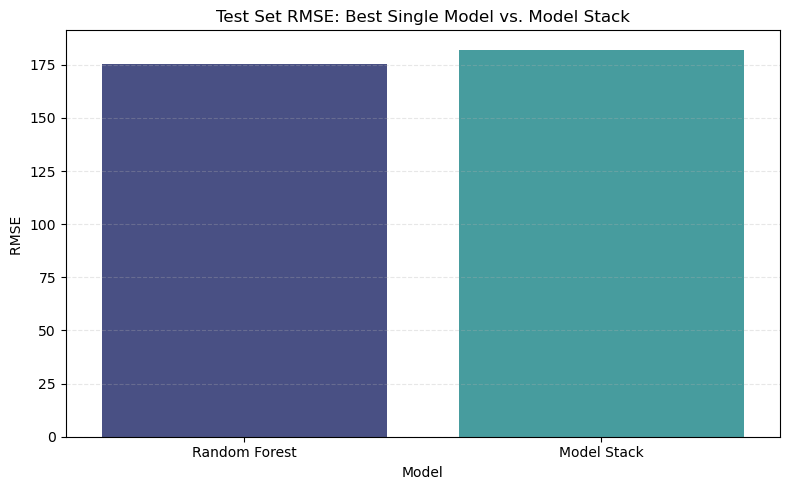

In [47]:
# compare the results
compare_df = pd.DataFrame({
    "Model": [best_single_model, "Model Stack"],
    "RMSE": [test_rmse, stack_rmse],
    "R2": [test_r2, stack_r2],
    "MAE": [test_mae, stack_mae]
})

# print result
print("\n Performance Comparison on Test Set:")
display(compare_df)

# visualization
plt.figure(figsize=(8, 5))
sns.barplot(data=compare_df, x="Model", y="RMSE", palette="mako")
plt.title("Test Set RMSE: Best Single Model vs. Model Stack")
plt.ylabel("RMSE ")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

In [48]:
if stack_rmse < test_rmse:
    print(f" The Stacked Model slightly outperformed the Best Single Model ({best_single_model}).")
    print(f"Recommended for deployment due to improved generalisation (RMSE ↓ from {test_rmse:.2f} to {stack_rmse:.2f}).")
else:
    print(f" Best Single Model ({best_single_model}) remains competitive (RMSE: {test_rmse:.2f}) and is easier to maintain.")
    print("Recommended for deployment due to simplicity and comparable performance.")

 Best Single Model (Random Forest) remains competitive (RMSE: 175.32) and is easier to maintain.
Recommended for deployment due to simplicity and comparable performance.
